# Logging to a file

## Overview

### Questions

* What is a Logger?
* How can I write thermodynamic and other quantities to a file?
* How can I access that data?

### Objectives

* Describe and give examples of **loggable quantities**.
* Show how to add quantities to a **Logger**.
* Demonstrate **HDF5Log** as a log writer.
* Explain how to read logged quantities from **HDF5** files.
* Describe how **namespaces** appear in the names of the logged quantities.

## Boilerplate Code

In [1]:
import hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
import os

fn = os.path.join(os.getcwd(), "log.h5")
![ -e "$fn" ] && rm "$fn"

## Introduction

HOOMD separates logging into three parts: **Loggable quantities**, the **Logger** class, and 
**Writers**.

* **Loggable quantities** are values computed during a simulation.
* The **Logger** class provides a way to collect and name quantities of interest.
* **Writers** write these values out in a format you can later use.

In this section, you will use the **HDF5Log Writer** to capture the values of quantities during a simulation run for later analysis.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dynamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [3]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(
    filename="../01-Introducing-Molecular-Dynamics/random.gsd"
)

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator
simulation.run(0)

## Loggable Quantities

Many classes in HOOMD-blue provide special *properties* called **loggable quantities**.
For example, the **Simulation** class provides `timestep`, `tps`, and others.
The reference documentation labels each of these as _Loggable_.
You can also examine the ``loggables`` property to determine the **loggable quantities**:

In [4]:
simulation.loggables

{'timestep': 'scalar',
 'seed': 'scalar',
 'tps': 'scalar',
 'walltime': 'scalar',
 'final_timestep': 'scalar',
 'initial_timestep': 'scalar'}

The **ThermodynamicQuantities** class computes a variety of **thermodynamic properties** in MD simulations.
These are all loggable.

In [5]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)
thermodynamic_properties.loggables

{'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar',
 'volume': 'scalar'}

**Loggable quantities** are class properties or methods.
You can directly access them in your code.

In [6]:
simulation.timestep

10000

In [7]:
thermodynamic_properties.kinetic_temperature

1.4860997961035969

Each **loggable quantity** has a **category**, which is listed both in the reference documentation and in ``loggables``.
The **category** is a string that identifies the quantity's type or category.
Example categories include:
* `scalar` - numbers
* `sequence` - arrays of numbers
* `string` - strings of characters
* `particle` - arrays of per-particle values

## Add Quantities to a Logger

Add each of the quantities you would like to store to a **Logger**.
The **Logger** will maintain these quantities in a list and provide them to the **Writer** when needed.

In [8]:
logger = hoomd.logging.Logger(categories=["scalar", "sequence"])

You can add **loggable quantities** from any number of objects to a **Logger**.
**Logger** uses the namespace of the class to assign a unique name for each quantity.
Call `add` to add all quantities provided by `thermodynamic_properties`:

In [9]:
logger.add(thermodynamic_properties)

You can also select specific quantities to add with the `quantities` argument.
Add only the `timestep` and `walltime` quantities from **Simulation**:

In [10]:
logger.add(simulation, quantities=["timestep", "walltime"])

## Writing Log Quantities to a File

Use the **HDF5Log** writer to store the quantities provided by `logger` to a HDF5 (`.h5`) file.

In [11]:
hdf5_writer = hoomd.write.HDF5Log(
    trigger=hoomd.trigger.Periodic(1000), filename="log.h5", mode="x", logger=logger
)
simulation.operations.writers.append(hdf5_writer)

The writer triggers and writes to the log file when the simulation runs:

In [12]:
simulation.run(100_000)

Remove the writer from the simulation to close the file:

<div class="alert alert-info">
This step is not necessary in typical workflows where a simulation script writes a log file and exits before a later analysis script reads the file.
</div>

In [13]:
simulation.operations.writers.remove(hdf5_writer)

## Reading Logged Data From a HDF5 File

HDF5 is a **binary** file format. You must use tools that support the format to access the file. The HDF5 library provides command line tools to examine the file contents interactively. `h5ls` lists the datasets in the file:

<div class="alert alert-info">
In Jupyter, the “!” magic command is equivalent to typing the given command in a shell.
</div>

In [14]:
!h5ls -r log.h5

/                        Group
/hoomd-data              Group
/hoomd-data/Simulation   Group
/hoomd-data/Simulation/timestep Dataset {100/Inf}
/hoomd-data/Simulation/walltime Dataset {100/Inf}
/hoomd-data/md           Group
/hoomd-data/md/compute   Group
/hoomd-data/md/compute/ThermodynamicQuantities Group
/hoomd-data/md/compute/ThermodynamicQuantities/degrees_of_freedom Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/kinetic_energy Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/num_particles Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/potential_energy Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/pressure Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor Dataset {100/Inf, 6}
/hoomd-data/md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom Dataset {100/Inf}
/hoomd-data/md/compute/Thermo

The datasets have verbose names that include the **namespace** of the class which computed the quantity, where `.` has been replaced with `/`.
For example, access the potential energy computed by **ThermodynamicQuantities** with the key `/hoomd-data/md/compute/ThermodynamicQuantities/potential_energy`.

`h5dump` writes the contents of HDF5 files in a human readable form:

In [15]:
!h5dump -d /hoomd-data/md/compute/ThermodynamicQuantities/potential_energy log.h5

HDF5 "log.h5" {
DATASET "/hoomd-data/md/compute/ThermodynamicQuantities/potential_energy" {
   DATATYPE  H5T_IEEE_F64LE
   DATASPACE  SIMPLE { ( 100 ) / ( H5S_UNLIMITED ) }
   DATA {
   (0): -510.01, -543.135, -524.447, -536.901, -535.059, -529.054, -529.558,
   (7): -534.636, -549.401, -541.593, -529.172, -544.702, -528.914, -550.572,
   (14): -570.383, -550.657, -558.646, -526.282, -536.786, -554.575,
   (20): -548.795, -584.865, -547.535, -542.064, -538.314, -536.727,
   (26): -533.673, -523.838, -525.317, -554.72, -539.575, -545.996, -546.25,
   (33): -544.511, -546.175, -543.33, -550.968, -549.793, -554.763, -545.316,
   (40): -566.029, -528.408, -560.351, -556.57, -566.635, -558.413, -529.437,
   (47): -515.214, -543.837, -549.649, -562.917, -528.231, -559.49, -503.152,
   (54): -531.272, -511.756, -537.821, -545.926, -528.392, -519.547,
   (60): -561.815, -532.213, -527.531, -538.488, -545.853, -539.998, -547.81,
   (67): -555.862, -542.059, -551.439, -541.837, -530.774, -545.48

Use the `h5py` package to read HDF5 files in Python:

In [16]:
import h5py

hdf5_file = h5py.File(name="log.h5", mode="r")

Index into the file object similar to a dictionary:

In [17]:
hdf5_file["hoomd-data/md/compute/ThermodynamicQuantities/potential_energy"]

<HDF5 dataset "potential_energy": shape (100,), type "<f8">

Access the dataset entries with a slice:

In [18]:
hdf5_file["hoomd-data/md/compute/ThermodynamicQuantities/potential_energy"][:]

array([-510.0098145 , -543.13513717, -524.44714588, -536.90088281,
       -535.05868103, -529.05397991, -529.557779  , -534.63644998,
       -549.4008136 , -541.59292613, -529.17204654, -544.70236587,
       -528.91365638, -550.57235559, -570.38252097, -550.65697382,
       -558.64569513, -526.2817986 , -536.78608236, -554.57466489,
       -548.79470741, -584.8649987 , -547.53487641, -542.06368402,
       -538.31426932, -536.72664941, -533.67341483, -523.83811311,
       -525.31679096, -554.71964079, -539.57510745, -545.99642014,
       -546.24997573, -544.51132989, -546.17476372, -543.32967633,
       -550.96807728, -549.79266769, -554.76327604, -545.31577746,
       -566.02888241, -528.40817493, -560.35072274, -556.57013416,
       -566.63549097, -558.41317062, -529.43652736, -515.21410491,
       -543.83694203, -549.6488847 , -562.917224  , -528.23116746,
       -559.48996421, -503.15207404, -531.27167469, -511.75604768,
       -537.82118086, -545.92614578, -528.39151356, -519.54734

Use a `h5py` dataset slice wherever you would normally use NumPy arrays. For example, plot the time series data:

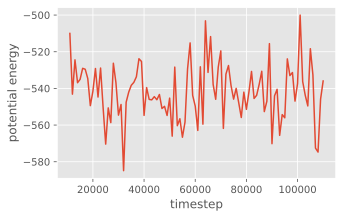

In [19]:
timestep = hdf5_file["hoomd-data/Simulation/timestep"][:]
potential_energy = hdf5_file[
    "hoomd-data/md/compute/ThermodynamicQuantities/potential_energy"
][:]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel("timestep")
ax.set_ylabel("potential energy")
fig

`HDF5Log` writes sequence, particle, bond, etc... quantities in addition to scalers. For example, the pressure tensor is a 6 element array on each frame:

In [20]:
hdf5_file["hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor"][0]

array([ 0.62729309,  0.141294  , -0.15755013,  0.24673519,  0.0743694 ,
        0.68500648])

In this section, you have logged quantities to a file during a simulation run and analyzed that data as a time series.
The next section of this tutorial shows you how to save per-particle quantities associated with specific system configurations.